In [1]:
import scanpy as sc
import scipy
from scipy.sparse import issparse
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import gc
import psutil
from typing import Optional, Tuple, Dict, Any
import logging

# configre logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
# load corrected and uncorrected data
adata_corrected = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/aging_all_2024/objects/cellbender_corrected_ref.h5ad')
adata_uncorrected = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/aging_all_2024/objects/major_celltype_updated_ref.h5ad')

/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
adata_corrected

AnnData object with n_obs × n_vars = 58604 × 32285
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'swapping_fraction_dist_params', 'target_false_positive_rate'
    obsm: 'gene_expression_encoding'

In [15]:
adata_uncorrected

AnnData object with n_obs × n_vars = 40106 × 20513
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition'
    var: 'highly_variable'
    uns: 'harmony', 'neighbors', 'pca'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs', 'harmony'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'nn', 'snn'

In [23]:
dup_mask = adata_corrected.obs.index.duplicated(keep=False)

# Extract duplicated barcodes and their counts
duplicates = adata_corrected.obs.index[dup_mask]
duplicate_cells = duplicates.value_counts()

print("Number of duplicated barcodes in corrected data:", len(duplicate_cells))
print(duplicate_cells)
#find if common genes is unique in index object
unique_genes_corrected = adata_corrected.var.index.unique()
print(f"Unique genes in corrected data: {len(unique_genes_corrected)}")

Number of duplicated barcodes in corrected data: 0
Series([], Name: count, dtype: int64)
Unique genes in corrected data: 32245


In [12]:
# Keep only the last part after the last "_"
adata_uncorrected.obs.index = adata_uncorrected.obs.index.str.rsplit("_", n=1).str[-1]

In [24]:
for ad in (adata_uncorrected, adata_corrected):
    # Ensure string dtype
    ad.obs_names = ad.obs_names.astype(str)
    ad.var_names = ad.var_names.astype(str)
    # Remove duplicates by appending -1, -2, ...
    ad.obs_names_make_unique()
    ad.var_names_make_unique()

#### Subset to the same cells and genes and transfer metadata from cellbender to the combined adata

In [25]:
# find overlapping cells
common_cells = adata_uncorrected.obs.index.intersection(adata_corrected.obs.index)
common_genes = adata_uncorrected.var.index.intersection(adata_corrected.var.index)
print(f"Found {len(common_cells)} common cells")
print(f"Found {len(common_genes)} common genes")

Found 39960 common cells
Found 20500 common genes


In [27]:
adata_orig_subset = adata_uncorrected[common_cells, common_genes].copy()
adata_corrected_subset = adata_corrected[common_cells, common_genes].copy()

In [28]:
# copy over all processed data
adata_combined = adata_orig_subset.copy()

In [29]:
# add cellbender counts as layer
adata_combined.layers['cellbender'] = adata_corrected_subset.X.copy()

In [30]:
print("Transferring cell metadata (obs)...")
for col in adata_corrected_subset.obs.columns:
    if col not in adata_combined.obs.columns:
        # Initialize new column with appropriate dtype
        if adata_corrected_subset.obs[col].dtype == 'object':
            adata_combined.obs[col] = pd.NA
        else:
            adata_combined.obs[col] = np.nan
    
    # Update values for common cells
    adata_combined.obs[col] = adata_corrected_subset.obs[col]

Transferring cell metadata (obs)...


In [31]:
adata_combined.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,log10GenesPerUMI,seurat_clusters,RNA_snn_res.0.6,cell_type,condition,background_fraction,cell_probability,cell_size,droplet_efficiency
AAACCCAAGATTCGAA-1,F7_KO,4350.0,1839,0.781609,0.897236,1,1,Fast IIX,KO,0.031034,0.999955,4220.201172,1.249208
AAACCCACACTCATAG-1,F7_KO,3258.0,1437,1.381215,0.898805,0,0,Fast IIB,KO,0.038591,0.998573,3995.092041,1.000975
AAACCCACAGCCTTCT-1,F7_KO,5633.0,2080,0.479148,0.884717,1,1,Fast IIX,KO,0.020231,0.999955,5067.773438,1.299482
AAACCCACAGTATGAA-1,F7_KO,5423.0,2025,0.976778,0.885550,1,1,Fast IIX,KO,0.025974,0.999955,4462.444336,1.488916
AAACCCACATCATTGG-1,F7_KO,2051.0,1085,2.291565,0.916504,1,1,Fast IIX,KO,0.119454,0.999957,3054.103760,0.886010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCAGAGCAG-1,M11_WT,4610.0,1693,0.802603,0.881256,5,5,Fast IIX,WT,0.028633,0.999955,5118.618652,1.049157
TTTGTTGTCCCAGGCA-1,M11_WT,6693.0,2115,0.448163,0.869260,0,0,Fast IIB,WT,0.014341,0.999955,5854.142578,1.305728
TTTGTTGTCGAAGTGG-1,M11_WT,1897.0,964,0.790722,0.910316,4,4,Fast IIB,WT,0.149474,0.999774,2945.320312,0.861436
TTTGTTGTCGAGAGCA-1,M11_WT,5340.0,2031,0.262172,0.887370,4,4,Fast IIB,WT,0.019835,0.999955,4644.250000,1.367892


In [32]:
# Transfer obsm with logging
print(f"Transferring {len(adata_corrected_subset.obsm.keys())} obsm entries:")
for key in adata_corrected_subset.obsm.keys():
    print(f"  - {key}: {adata_corrected_subset.obsm[key].shape}")
    adata_combined.obsm[key] = adata_corrected_subset.obsm[key].copy()

# Transfer varm with logging
print(f"Transferring {len(adata_corrected_subset.varm.keys())} varm entries:")
for key in adata_corrected_subset.varm.keys():
    print(f"  - {key}: {adata_corrected_subset.varm[key].shape}")
    adata_combined.varm[key] = adata_corrected_subset.varm[key].copy()

# Transfer uns with logging
print(f"Transferring {len(adata_corrected_subset.uns.keys())} uns entries:")
for key in adata_corrected_subset.uns.keys():
    print(f"  - {key}")
    adata_combined.uns[key] = adata_corrected_subset.uns[key]

Transferring 1 obsm entries:
  - gene_expression_encoding: (39960, 64)
Transferring 0 varm entries:
Transferring 14 uns entries:
  - cell_size_lognormal_std
  - empty_droplet_size_lognormal_loc
  - empty_droplet_size_lognormal_scale
  - estimator
  - features_analyzed_inds
  - fraction_data_used_for_testing
  - learning_curve_learning_rate_epoch
  - learning_curve_learning_rate_value
  - learning_curve_test_elbo
  - learning_curve_test_epoch
  - learning_curve_train_elbo
  - learning_curve_train_epoch
  - swapping_fraction_dist_params
  - target_false_positive_rate


In [34]:
adata_combined

AnnData object with n_obs × n_vars = 39960 × 20500
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency'
    var: 'highly_variable'
    uns: 'harmony', 'neighbors', 'pca', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'swapping_fraction_dist_params', 'target_false_positive_rate'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'gene_expression_encoding'
    varm: 'PCs', 'harmony'
    layers: 'counts', 'cellbender'
    obsp: 'connectivities', 'distances', 'nn', 'snn'

In [33]:
# write combined adata
adata_combined.write_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/aging_all_2024/objects/ref_cellbender_orig_combined.h5ad')

In [2]:
adata_combined = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/aging_all_2024/objects/ref_cellbender_orig_combined.h5ad')

In [3]:
adata_combined

AnnData object with n_obs × n_vars = 39960 × 20500
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency'
    var: 'highly_variable'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'harmony', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'neighbors', 'pca', 'swapping_fraction_dist_params', 'target_false_positive_rate'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'gene_expression_encoding'
    varm: 'PCs', 'harmony'
    layers: 'cellbender', 'counts'
    obsp: 'connectivities', 'distances', 'nn', 'snn'

<Axes: title={'center': 'cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>

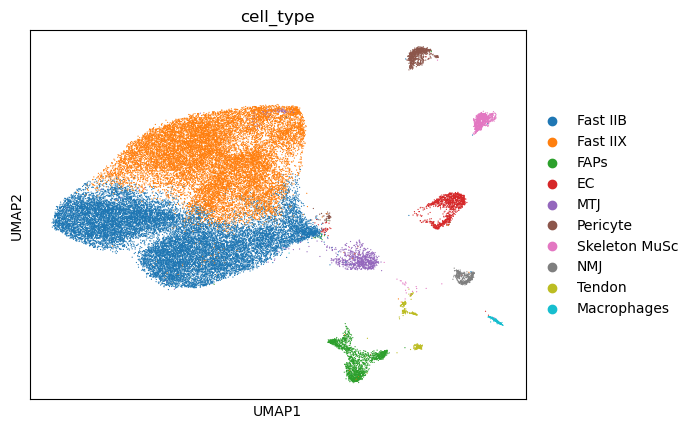

In [8]:
sc.pl.umap(adata_combined, color=['cell_type'], show=False)

## Compare cellbender counts to uncorrected counts

In [4]:
adata_combined

AnnData object with n_obs × n_vars = 39960 × 20500
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency'
    var: 'highly_variable'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'harmony', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'neighbors', 'pca', 'swapping_fraction_dist_params', 'target_false_positive_rate'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'gene_expression_encoding'
    varm: 'PCs', 'harmony'
    layers: 'cellbender', 'counts'
    obsp: 'connectivities', 'distances', 'nn', 'snn'

In [5]:
# Calculate QC metrics
adata_combined.var['mt'] = adata_combined.var_names.str.startswith('mt-')
adata_combined.var['ribo'] = adata_combined.var_names.str.startswith(('rps', 'rpl'))
adata_combined.var["hb"] = adata_combined.var_names.str.contains("^hb[^(p)]")

sc.pp.calculate_qc_metrics(
    adata_combined, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata_combined

AnnData object with n_obs × n_vars = 39960 × 20500
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'highly_variable', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'harmony', 'learning_curve_learning_rate_epoch', 'learning_curve_l

In [6]:
adata_combined.X = adata_combined.layers['cellbender']

In [7]:
# Calculate QC metrics
adata_combined.var['mt_cb'] = adata_combined.var_names.str.startswith('mt-')
adata_combined.var['ribo_cb'] = adata_combined.var_names.str.startswith(('rps', 'rpl'))
adata_combined.var["hb_cb"] = adata_combined.var_names.str.contains("^hb[^(p)]")

sc.pp.calculate_qc_metrics(
    adata_combined, qc_vars=["mt_cb", "ribo_cb", "hb_cb"], inplace=True, percent_top=[20], log1p=True
)
adata_combined

AnnData object with n_obs × n_vars = 39960 × 20500
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb'
    var: 'highly_variable', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt_cb', 'ribo_cb', 'hb_cb'
    

In [ ]:
# cut of cells to compare cellbender vs uncorrected counts on the same scale
adata_combined = adata_combined[adata_combined.obs['total_counts_mt_cb'] < 50]

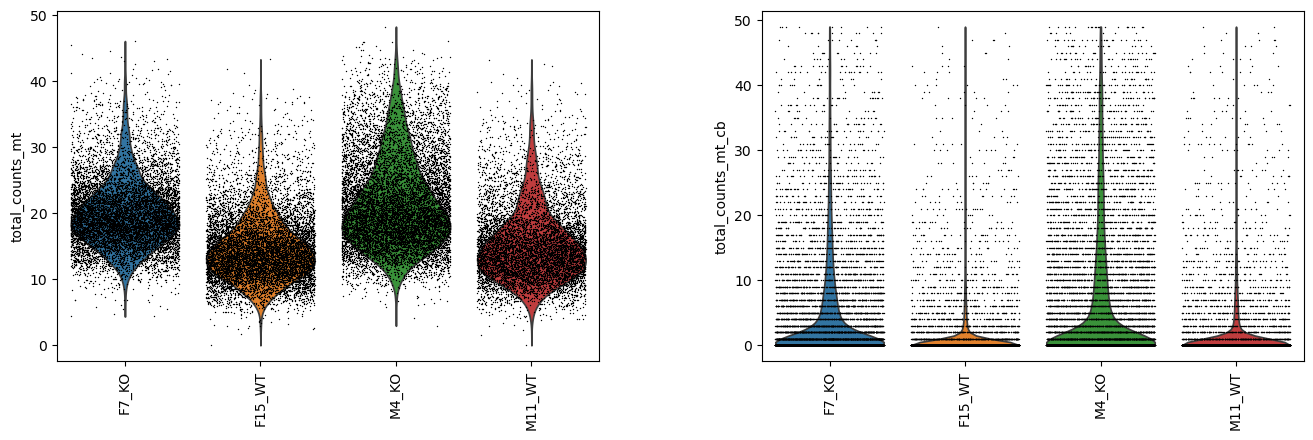

In [11]:
sc.pl.violin(
    adata_combined,
    ["total_counts_mt", "total_counts_mt_cb"],
    groupby='orig.ident',
    jitter=0.4,
    multi_panel=True,
    rotation=90
)

In [4]:
marker_genes = [
    "Ano4", "Prkar1a", "Usp1", "Col13a1", "Tnxb", "Egfr", "Gsn",
    "Abi3bp", "Ptprd", "Col22a1", "Adamts20", "App", "Trpc3", "Cacna1c",
    "Slc35f1", "Hs6st3", "Chodl", "Pax7", "Flt1", "Mecom",
    "Dach1", "Pecam1", "F13a1", "Mctp1", "Slc9a9", "Actn3", "Sorbs2", "Xpr1",
    "Myh1", "Kcnn2", "Acss2", "Fhl1"
]

# marker_genes_dict = {
#     "Pericyte": ["Egfr", "Trpc3", "Cacna1c", "Slc35f1", "Myh1"],
#     "EC": ["App", "Flt1", "Mecom", "Dach1", "Pecam1" ],
#     "Tendon": ["Egfr", "Gsn", "Abi3bp", "Ptprd", "Cacna1c", "Myh1"],
#     "FAPs": ["Myh1", "App", "Abi3bp", "Tnxb", "Egfr", "Gsn"],
#     "Macrophages": ["Gsn", "App", "F13a1", "Mctp1", "Slc9a9", "Myh1"],
#     "Skeleton MuSc": ["Egfr", "Ptprd", "Hs6st3", "Chodl", "Pax7", "Myh1"],
#     "Fast IIX": ["Actn3", "Xpr1", "Myh1", "Kcnn2", "Acss2", "Fhl1"],
#     "Fast IIB": ["Actn3", "Sorbs2", "Xpr1", "Myh1", "Kcnn2"],
#     "MTJ": ["Col22a1", "Adamts20", "App", "Actn3", "Sorbs2", "Xpr1", "Myh1", "Acss2", "Fhl1" ],
#     "NMJ": ["Ano4", "Prkar1a", "Col13a1", "Ptprd", "App", "Actn3", "Xpr1", "Myh1", "Acss2", "Fhl1" ]
# }

marker_genes_dict = {
    "Pericyte": marker_genes,
    "EC": marker_genes,
    "Tendon": marker_genes,
    "FAPs": marker_genes,
    "Macrophages": marker_genes,
    "Skeleton MuSc": marker_genes,
    "Fast IIX": marker_genes,
    "Fast IIB": marker_genes,
    "MTJ": marker_genes,
    "NMJ": marker_genes
}

{'mainplot_ax': <Axes: >,
 'size_legend_ax': <Axes: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

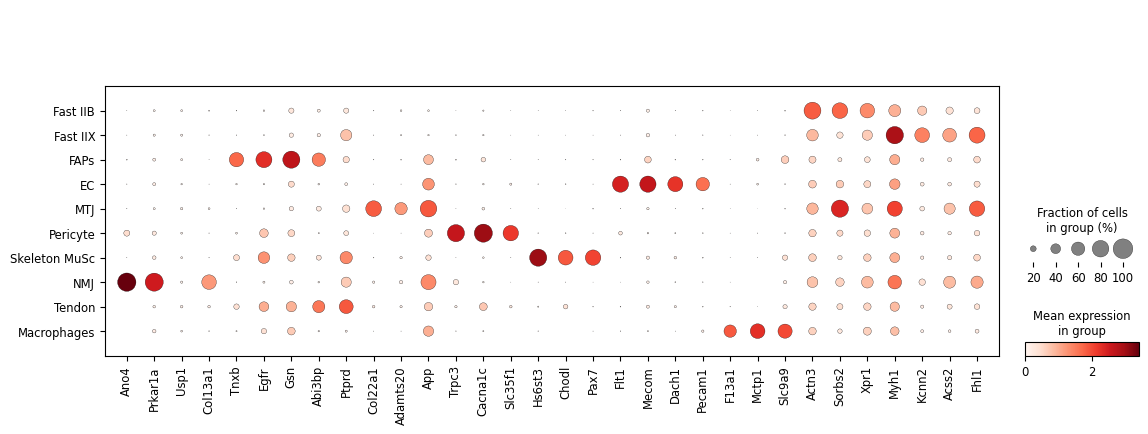

In [5]:
# plot dotplot of marker genes and cell types
sc.pl.dotplot(adata_combined, marker_genes, groupby='cell_type', show=False)